# SECOM Yield Prediction — End-to-End Notebook

**Goal:** Predict *Fail* outcomes from process measurements to reduce scrap and downtime.

**Data:** `data/secom.data`, `data/secom_labels.data`, `data/secom.names` (UCI ML Repository, real fab data).

**Primary metric:** Recall on *Fail* at acceptable precision. Report PR-AUC and Balanced Error Rate (BER).

> Safety: No unsupported claims. Treat outputs as decision support, not automation.

### 1. Setup

In [1]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib


# Global style for plots
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1,
    "xtick.color": "black",
    "ytick.color": "black",
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.bottom": True,
    "ytick.left": True,
    "xtick.top": False,
    "ytick.right": False,
    "figure.dpi": 150,
    "legend.frameon": True,
    "legend.facecolor": "white",
    "legend.edgecolor": "black",
    "legend.fontsize": 12
})

# Apply to seaborn
sns.set_theme(context="notebook", style="ticks")

# Reproducibility
rnd_num = 42
np.random.seed(rnd_num)

# Root directory
ROOT = Path(os.getcwd()).parent

# Data directory
DATA_DIR = Path(ROOT/"data")
RAW = Path(DATA_DIR/"raw")
assert (RAW/"secom.data").exists() and (RAW/"secom_labels.data").exists(), "Data files are missing!"

# Results directory
RESULT_DIR = Path(ROOT/"results")
RESULT_DIR.mkdir(exist_ok=True, parents=True)

# Model directory
MODEL_DIR = Path(ROOT/"models")
MODEL_DIR.mkdir(exist_ok=True, parents=True)

In [2]:
# Figure saver helper (use after each plot)
RESULT_DIR_M = Path(RESULT_DIR/"modeling")
RESULT_DIR_M.mkdir(exist_ok=True, parents=True)
def savefig(name):
    out = RESULT_DIR_M/name
    plt.tight_layout()
    plt.savefig(out, dpi=300, bbox_inches="tight")
    print("Saved:", out)

### 6. Modeling

#### 6.1. Load the data from ETL step,

In [3]:
# Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import torch, torch.nn as nn
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.isotonic import IsotonicRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_classif, mutual_info_classif

from sklearn.metrics import (precision_recall_curve, average_precision_score,
                             roc_auc_score, balanced_accuracy_score,
                             confusion_matrix, classification_report,
                             brier_score_loss)

In [4]:
# Load processed data produced by 02_ETL.ipynb
PROC = Path(DATA_DIR/"processed")
tr = pd.read_parquet(PROC/"train.parquet")
va = pd.read_parquet(PROC/"val.parquet")
te = pd.read_parquet(PROC/"test.parquet")

In [5]:
feat_cols = [c for c in tr.columns if c not in ("label","timestamp")]

Xtr = tr[feat_cols].to_numpy(dtype=np.float32)
ytr = tr["label"].to_numpy(dtype=np.int8)

Xva = va[feat_cols].to_numpy(dtype=np.float32)
yva = va["label"].to_numpy(dtype=np.int8)

Xte = te[feat_cols].to_numpy(dtype=np.float32)
yte = te["label"].to_numpy(dtype=np.int8)

# Global accumulator for leaderboard rows (dicts)
all_results = []

print("Shapes:", Xtr.shape, Xva.shape, Xte.shape, "| Pos rates:", ytr.mean(), yva.mean(), yte.mean())

Shapes: (940, 375) (313, 375) (314, 375) | Pos rates: 0.08085106382978724 0.03514376996805112 0.054140127388535034


#### 6.2. Utilities (threshold + metrics)

In [6]:
def pick_threshold_by_f1(y_true, proba):
    """Given true labels and predicted probabilities, find threshold maximizing F1."""
    """y_true: array-like of shape (n_samples,) - true binary labels (0/1)
       proba: array-like of shape (n_samples,) - predicted probabilities for the positive class
       returns: dict with keys 'thr', 'precision', 'recall', 'f1' at optimal threshold
    """
    p, r, t = precision_recall_curve(y_true, proba)
    f1 = (2*p*r)/(p+r+1e-12)
    j = np.argmax(f1)
    return {"thr": float(np.r_[t,1.0][j]), "precision": float(p[j]), "recall": float(r[j]), "f1": float(f1[j])}

In [7]:
def pick_threshold_by_recall(y_true, proba, recall_floor=0.10):
    """Given true labels and predicted probabilities, find threshold achieving at least recall_floor,
       and among those, maximizing precision.
       y_true: array-like of shape (n_samples,) - true binary labels (0/1)
       proba: array-like of shape (n_samples,) - predicted probabilities for the positive class
       recall_floor: float in (0,1) - minimum recall to achieve
       returns: dict with keys 'thr', 'precision', 'recall' at optimal threshold
    """
    p, r, t = precision_recall_curve(y_true, proba)
    ok = np.where(r >= recall_floor)[0]
    j = ok[np.argmax(p[ok])] if len(ok) else len(r)-1
    return {"thr": float(np.r_[t,1.0][j]), "precision": float(p[j]), "recall": float(r[j])}

In [8]:
def evaluate(y_true, proba, thr, name="model"):
    """Evaluate binary classifier at given threshold.
       y_true: array-like of shape (n_samples,) - true binary labels (0/1)
       proba: array-like of shape (n_samples,) - predicted probabilities for the positive class
       thr: float in [0,1] - threshold to convert proba to binary predictions
       name: str - name of the model for reporting
       returns: dict with metrics
    """
    pred = (proba >= thr).astype(int)
    pr = average_precision_score(y_true, proba)
    roc = roc_auc_score(y_true, proba)
    bal = balanced_accuracy_score(y_true, pred)
    tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
    print(f"\n== {name} @thr={thr:.3f} ==")
    print("Confusion:", (tn, fp, fn, tp), "| BalancedAcc:", round(bal,4),
          "| PR-AUC:", round(pr,4), "| ROC-AUC:", round(roc,4))
    print(classification_report(y_true, pred, digits=3))
    return {"Model": name, "PR_AUC": pr, "ROC_AUC": roc, "BalancedAcc": bal,
            "thr": thr, "TP": int(tp), "FP": int(fp), "TN": int(tn), "FN": int(fn)}

#### 6.3. Baseline: Logistic Regression

In [9]:
# fit on train only
lr = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=None)
lr.fit(Xtr, ytr)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


In [10]:
# tune threshold on validation
lr_proba_val = lr.predict_proba(Xva)[:,1]
lr_thr_f1 = pick_threshold_by_f1(yva, lr_proba_val)
lr_thr_rec = pick_threshold_by_recall(yva, lr_proba_val, recall_floor=0.10)
print("Val picks F1:", lr_thr_f1, "  Recall>=10%:", lr_thr_rec)

Val picks F1: {'thr': 0.9535520675964143, 'precision': 0.08333333333333333, 'recall': 0.09090909090909091, 'f1': 0.08695652173863137}   Recall>=10%: {'thr': 4.9330542038188725e-08, 'precision': 0.041353383458646614, 'recall': 1.0}


In [11]:
# final test evals
lr_proba_te = lr.predict_proba(Xte)[:,1]
lr_res_f1 = evaluate(yte, lr_proba_te, lr_thr_f1["thr"], name="Logistic | F1-opt")
lr_res_rec = evaluate(yte, lr_proba_te, lr_thr_rec["thr"], name="Logistic | Recall>=10%")

# Save lr_res_f1 and lr_res_rec
all_results.extend([lr_res_f1, lr_res_rec])


== Logistic | F1-opt @thr=0.954 ==
Confusion: (295, 2, 17, 0) | BalancedAcc: 0.4966 | PR-AUC: 0.1196 | ROC-AUC: 0.6425
              precision    recall  f1-score   support

           0      0.946     0.993     0.969       297
           1      0.000     0.000     0.000        17

    accuracy                          0.939       314
   macro avg      0.473     0.497     0.484       314
weighted avg      0.894     0.939     0.916       314


== Logistic | Recall>=10% @thr=0.000 ==
Confusion: (117, 180, 4, 13) | BalancedAcc: 0.5793 | PR-AUC: 0.1196 | ROC-AUC: 0.6425
              precision    recall  f1-score   support

           0      0.967     0.394     0.560       297
           1      0.067     0.765     0.124        17

    accuracy                          0.414       314
   macro avg      0.517     0.579     0.342       314
weighted avg      0.918     0.414     0.536       314



#### 6.4. Random Forest

In [12]:
# Fit on train
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
rf.fit(Xtr, ytr)

,n_estimators,400
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
# Thresholds from validation
rf_proba_val = rf.predict_proba(Xva)[:,1]
rf_thr_f1 = pick_threshold_by_f1(yva, rf_proba_val)
rf_thr_rec = pick_threshold_by_recall(yva, rf_proba_val, recall_floor=0.10)
print("Val picks -> F1:", rf_thr_f1, "  Recall≥10%:", rf_thr_rec)

Val picks -> F1: {'thr': 0.0675, 'precision': 0.06, 'recall': 0.5454545454545454, 'f1': 0.10810810810792953}   Recall≥10%: {'thr': 0.0675, 'precision': 0.06, 'recall': 0.5454545454545454}


In [14]:
# Final test evaluation
rf_proba_te = rf.predict_proba(Xte)[:,1]
rf_res_f1 = evaluate(yte, rf_proba_te, rf_thr_f1["thr"], name="RF | F1-opt")
rf_res_rec = evaluate(yte, rf_proba_te, rf_thr_rec["thr"], name="RF | Recall≥10%")

# Save rf_res_f1 and rf_res_rec
all_results.extend([rf_res_f1, rf_res_rec])


== RF | F1-opt @thr=0.068 ==
Confusion: (196, 101, 9, 8) | BalancedAcc: 0.5653 | PR-AUC: 0.0715 | ROC-AUC: 0.6172
              precision    recall  f1-score   support

           0      0.956     0.660     0.781       297
           1      0.073     0.471     0.127        17

    accuracy                          0.650       314
   macro avg      0.515     0.565     0.454       314
weighted avg      0.908     0.650     0.745       314


== RF | Recall≥10% @thr=0.068 ==
Confusion: (196, 101, 9, 8) | BalancedAcc: 0.5653 | PR-AUC: 0.0715 | ROC-AUC: 0.6172
              precision    recall  f1-score   support

           0      0.956     0.660     0.781       297
           1      0.073     0.471     0.127        17

    accuracy                          0.650       314
   macro avg      0.515     0.565     0.454       314
weighted avg      0.908     0.650     0.745       314



#### 6.5. MLP Baseline

In [15]:
device = torch.device("mps" if torch.backends.mps.is_available()
                      else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Torch device:", device)

Torch device: mps


In [16]:
# --- Define MLP ---
class MLP(nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 1)
        )
    def forward(self, x): return self.net(x)

In [17]:
def train_mlp(Xtrain, ytrain, Xval, yval, epochs=50, lr=1e-3):
    # tensors as float32
    Xt = torch.tensor(Xtrain, dtype=torch.float32, device=device)
    yt = torch.tensor(ytrain, dtype=torch.float32, device=device).unsqueeze(1)
    Xv = torch.tensor(Xval,   dtype=torch.float32, device=device)

    model = MLP(Xtrain.shape[1]).to(device).float()

    # class-weighted BCE (float32 pos_weight)
    pos_w = np.float32((1.0 - ytrain.mean()) / (ytrain.mean() + 1e-12))
    crit = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_w], dtype=torch.float32, device=device))
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    best_ap, best_state = -1.0, None
    for ep in range(50 if epochs is None else epochs):
        model.train(); opt.zero_grad()
        logits = model(Xt)
        loss = crit(logits, yt)
        loss.backward(); opt.step()

        model.eval()
        with torch.no_grad():
            pv = torch.sigmoid(model(Xv)).detach().cpu().numpy().astype("float32").ravel()
        ap = average_precision_score(yval, pv)
        if ap > best_ap:
            best_ap = ap
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    model.eval()
    with torch.no_grad():
        p_val = torch.sigmoid(model(Xv)).detach().cpu().numpy().astype("float32").ravel()
    return model, p_val, float(best_ap)

In [18]:
def train_mlp_probas(Xtrain, ytrain, Xval, yval, Xtest, epochs=60, lr=1e-3):
    import numpy as np
    import torch, torch.nn as nn

    # tensors (float32) on current device
    Xt  = torch.tensor(Xtrain, dtype=torch.float32, device=device)
    yt  = torch.tensor(np.asarray(ytrain), dtype=torch.float32, device=device).view(-1, 1)
    Xv  = torch.tensor(Xval,   dtype=torch.float32, device=device)
    Xte = torch.tensor(Xtest,  dtype=torch.float32, device=device)

    class MLP(nn.Module):
        def __init__(self, d_in):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(d_in, 256), nn.ReLU(), nn.Dropout(0.2),
                nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.2),
                nn.Linear(128, 1)
            )
        def forward(self, x): return self.net(x)

    model = MLP(Xtrain.shape[1]).to(device)
    pos_w = (1 - np.mean(ytrain)) / (np.mean(ytrain) + 1e-12)
    crit = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_w], dtype=torch.float32, device=device))
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    best_ap, best_state = -1.0, None
    for _ in range(epochs):
        model.train(); opt.zero_grad()
        out = model(Xt); loss = crit(out, yt); loss.backward(); opt.step()

        model.eval()
        with torch.no_grad():
            pv = torch.sigmoid(model(Xv)).cpu().numpy().ravel()
        from sklearn.metrics import average_precision_score
        ap = average_precision_score(np.asarray(yval), pv)
        if ap > best_ap:
            best_ap, best_state = ap, {k: v.detach().cpu() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

    model.eval()
    with torch.no_grad():
        p_val = torch.sigmoid(model(Xv)).cpu().numpy().ravel()
        p_te  = torch.sigmoid(model(Xte)).cpu().numpy().ravel()

    return p_val, p_te, float(best_ap)

In [19]:
# --- Train on train, tune on val ---
mlp_model, p_val_mlp, ap_val = train_mlp(Xtr, ytr, Xva, yva, epochs=60)

In [20]:
# thresholds from validation
mlp_thr_f1  = pick_threshold_by_f1(yva, p_val_mlp)
mlp_thr_rec = pick_threshold_by_recall(yva, p_val_mlp, recall_floor=0.10)
print("Val picks F1:", mlp_thr_f1, "  Recall>=10%:", mlp_thr_rec)

Val picks F1: {'thr': 0.15090911090373993, 'precision': 0.054187192118226604, 'recall': 1.0, 'f1': 0.10280373831765949}   Recall>=10%: {'thr': 0.15090911090373993, 'precision': 0.054187192118226604, 'recall': 1.0}


In [21]:
# get probas to feed ensembles
mlp_proba_val, mlp_proba_te, mlp_ap = train_mlp_probas(Xtr, ytr, Xva, yva, Xte, epochs=60)
print("MLP val AP:", round(mlp_ap, 4))

MLP val AP: 0.0768


In [22]:
# test evaluation
Xtest_t = torch.tensor(Xte, dtype=torch.float32, device=device)
with torch.no_grad():
    p_test_mlp = torch.sigmoid(mlp_model(Xtest_t)).detach().cpu().numpy().astype("float32").ravel()

mlp_res_f1 = evaluate(yte, p_test_mlp, mlp_thr_f1["thr"],  name="MLP | F1-opt")
mlp_res_rec = evaluate(yte, p_test_mlp, mlp_thr_rec["thr"], name="MLP | Recall≥10%")

# after computing mlp_res_f1 and mlp_res_rec
all_results.extend([mlp_res_f1, mlp_res_rec])


== MLP | F1-opt @thr=0.151 ==
Confusion: (153, 144, 5, 12) | BalancedAcc: 0.6105 | PR-AUC: 0.0736 | ROC-AUC: 0.5847
              precision    recall  f1-score   support

           0      0.968     0.515     0.673       297
           1      0.077     0.706     0.139        17

    accuracy                          0.525       314
   macro avg      0.523     0.611     0.406       314
weighted avg      0.920     0.525     0.644       314


== MLP | Recall≥10% @thr=0.151 ==
Confusion: (153, 144, 5, 12) | BalancedAcc: 0.6105 | PR-AUC: 0.0736 | ROC-AUC: 0.5847
              precision    recall  f1-score   support

           0      0.968     0.515     0.673       297
           1      0.077     0.706     0.139        17

    accuracy                          0.525       314
   macro avg      0.523     0.611     0.406       314
weighted avg      0.920     0.525     0.644       314



#### 6.6. Calibration of Probabilities

In [23]:
# --- fit a calibrator on validation probs, return a callable ---
def fit_calibrator(y_val, p_val, method="isotonic"):
    if method == "isotonic":
        iso = IsotonicRegression(out_of_bounds="clip")
        iso.fit(p_val, y_val)
        return lambda p: iso.transform(p)
    elif method == "sigmoid":
        lr_cal = LogisticRegression(solver="lbfgs")
        # Platt scaling: logit(p) as feature; clip to avoid inf
        eps = 1e-6
        z = np.log(np.clip(p_val, eps, 1-eps) / np.clip(1-p_val, eps, 1-eps)).reshape(-1,1)
        lr_cal.fit(z, y_val)
        return lambda p: lr_cal.predict_proba(
            np.log(np.clip(p, eps, 1-eps) / np.clip(1-p, eps, 1-eps)).reshape(-1,1)
        )[:,1]
    else:
        raise ValueError("method must be 'isotonic' or 'sigmoid'")

def calibrate_and_eval_prefit(base_model, name, Xva, yva, Xte, yte, method):
    # get uncalibrated probabilities
    p_val = base_model.predict_proba(Xva)[:,1]
    p_te  = base_model.predict_proba(Xte)[:,1]
    # fit calibrator on validation
    cal = fit_calibrator(yva, p_val, method=method)
    p_val_cal = cal(p_val)
    p_te_cal  = cal(p_te)

    # thresholds picked on validation-calibrated
    thr_f1  = pick_threshold_by_f1(yva, p_val_cal)
    thr_rec = pick_threshold_by_recall(yva, p_val_cal, recall_floor=0.10)
    print(f"\n{name} ({method}) calibration")
    print("Val picks --> F1:", thr_f1, "  Recall≥10%:", thr_rec)

    # test eval
    res_f1  = evaluate(yte, p_te_cal, thr_f1["thr"],  name=f"{name} ({method}) | F1-opt")
    res_rec = evaluate(yte, p_te_cal, thr_rec["thr"], name=f"{name} ({method}) | Recall≥10%")
    print("Brier score (test):", round(brier_score_loss(yte, p_te_cal), 4))
    return res_f1, res_rec

In [24]:
# --- Logistic Regression (already trained as lr) ---
lr_iso_res_f1,  lr_iso_res_rec = calibrate_and_eval_prefit(lr, "Logistic",      Xva, yva, Xte, yte, method="isotonic")
lr_sig_res_f1,  lr_sig_res_rec = calibrate_and_eval_prefit(lr, "Logistic",      Xva, yva, Xte, yte, method="sigmoid")

# Save LR calibrated
all_results.extend([lr_iso_res_f1, lr_iso_res_rec, lr_sig_res_f1, lr_sig_res_rec])


Logistic (isotonic) calibration
Val picks --> F1: {'thr': 0.08333333333333333, 'precision': 0.08333333333333333, 'recall': 0.09090909090909091, 'f1': 0.08695652173863137}   Recall≥10%: {'thr': 0.03937007874015748, 'precision': 0.041353383458646614, 'recall': 1.0}

== Logistic (isotonic) | F1-opt @thr=0.083 ==
Confusion: (295, 2, 17, 0) | BalancedAcc: 0.4966 | PR-AUC: 0.0642 | ROC-AUC: 0.576
              precision    recall  f1-score   support

           0      0.946     0.993     0.969       297
           1      0.000     0.000     0.000        17

    accuracy                          0.939       314
   macro avg      0.473     0.497     0.484       314
weighted avg      0.894     0.939     0.916       314


== Logistic (isotonic) | Recall≥10% @thr=0.039 ==
Confusion: (117, 180, 4, 13) | BalancedAcc: 0.5793 | PR-AUC: 0.0642 | ROC-AUC: 0.576
              precision    recall  f1-score   support

           0      0.967     0.394     0.560       297
           1      0.067     0.765

In [25]:
# --- Random Forest (already trained as rf) ---
rf_iso_res_f1,  rf_iso_res_rec = calibrate_and_eval_prefit(rf, "RandomForest",  Xva, yva, Xte, yte, method="isotonic")
rf_sig_res_f1,  rf_sig_res_rec = calibrate_and_eval_prefit(rf, "RandomForest",  Xva, yva, Xte, yte, method="sigmoid")

# Save RF calibrated
all_results.extend([rf_iso_res_f1, rf_iso_res_rec, rf_sig_res_f1, rf_sig_res_rec])


RandomForest (isotonic) calibration
Val picks --> F1: {'thr': 0.05747126436781609, 'precision': 0.06, 'recall': 0.5454545454545454, 'f1': 0.10810810810792953}   Recall≥10%: {'thr': 0.05747126436781609, 'precision': 0.06, 'recall': 0.5454545454545454}

== RandomForest (isotonic) | F1-opt @thr=0.057 ==
Confusion: (196, 101, 9, 8) | BalancedAcc: 0.5653 | PR-AUC: 0.0696 | ROC-AUC: 0.6173
              precision    recall  f1-score   support

           0      0.956     0.660     0.781       297
           1      0.073     0.471     0.127        17

    accuracy                          0.650       314
   macro avg      0.515     0.565     0.454       314
weighted avg      0.908     0.650     0.745       314


== RandomForest (isotonic) | Recall≥10% @thr=0.057 ==
Confusion: (196, 101, 9, 8) | BalancedAcc: 0.5653 | PR-AUC: 0.0696 | ROC-AUC: 0.6173
              precision    recall  f1-score   support

           0      0.956     0.660     0.781       297
           1      0.073     0.471   

#### 6.7. Leaderboard (auto-accumulate and render).

                                   Model  PR_AUC  ROC_AUC  BalancedAcc  \
0                      Logistic | F1-opt  0.1196   0.6425       0.4966   
1                 Logistic | Recall>=10%  0.1196   0.6425       0.5793   
2                           MLP | F1-opt  0.0736   0.5847       0.6105   
3                       MLP | Recall≥10%  0.0736   0.5847       0.6105   
4                            RF | F1-opt  0.0715   0.6172       0.5653   
5                        RF | Recall≥10%  0.0715   0.6172       0.5653   
6        RandomForest (sigmoid) | F1-opt  0.0715   0.6172       0.5653   
7    RandomForest (sigmoid) | Recall≥10%  0.0715   0.6172       0.5653   
8       RandomForest (isotonic) | F1-opt  0.0696   0.6173       0.5653   
9   RandomForest (isotonic) | Recall≥10%  0.0696   0.6173       0.5653   
10          Logistic (isotonic) | F1-opt  0.0642   0.5760       0.4966   
11      Logistic (isotonic) | Recall≥10%  0.0642   0.5760       0.5793   
12           Logistic (sigmoid) | F1-o

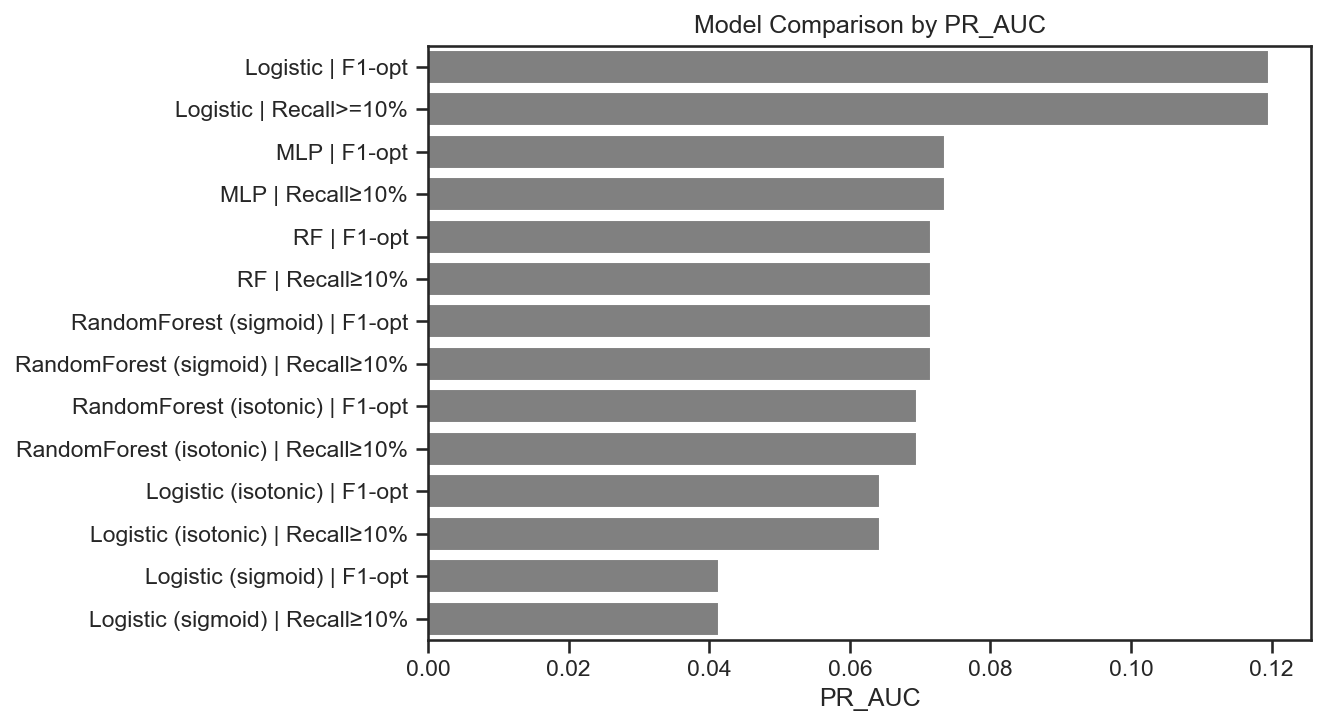

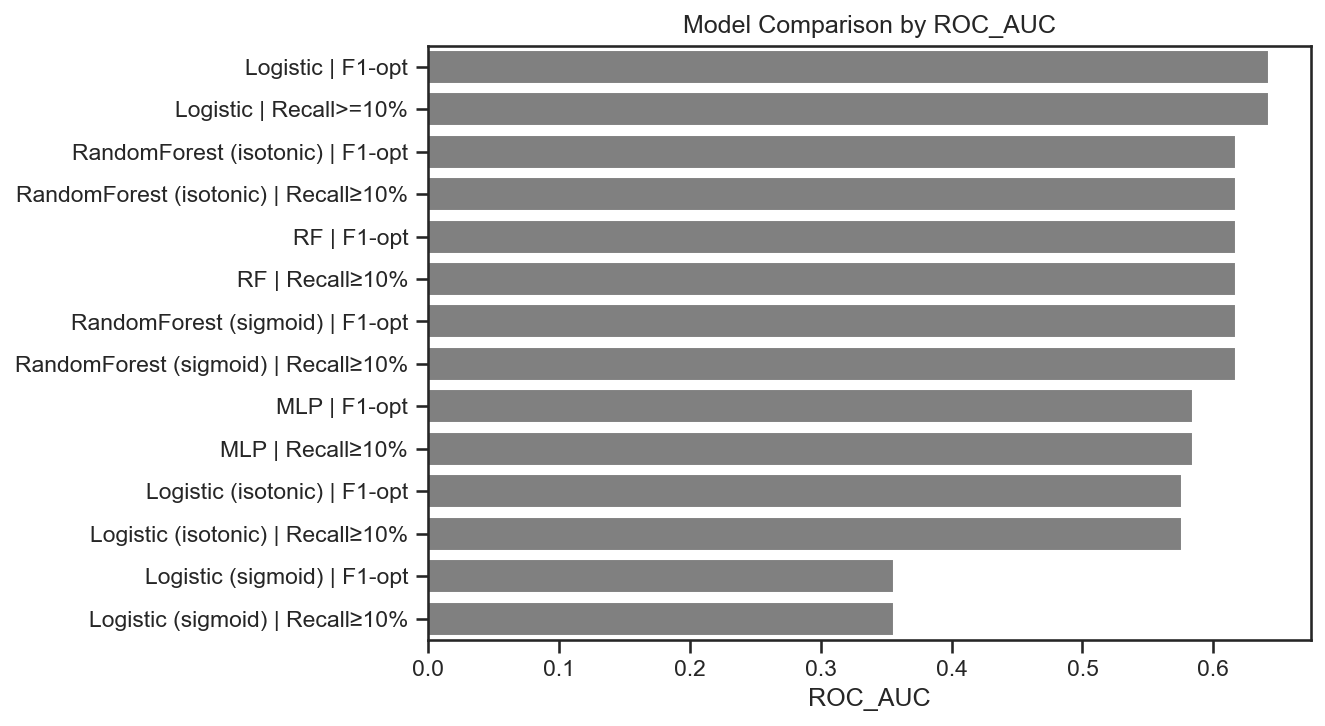

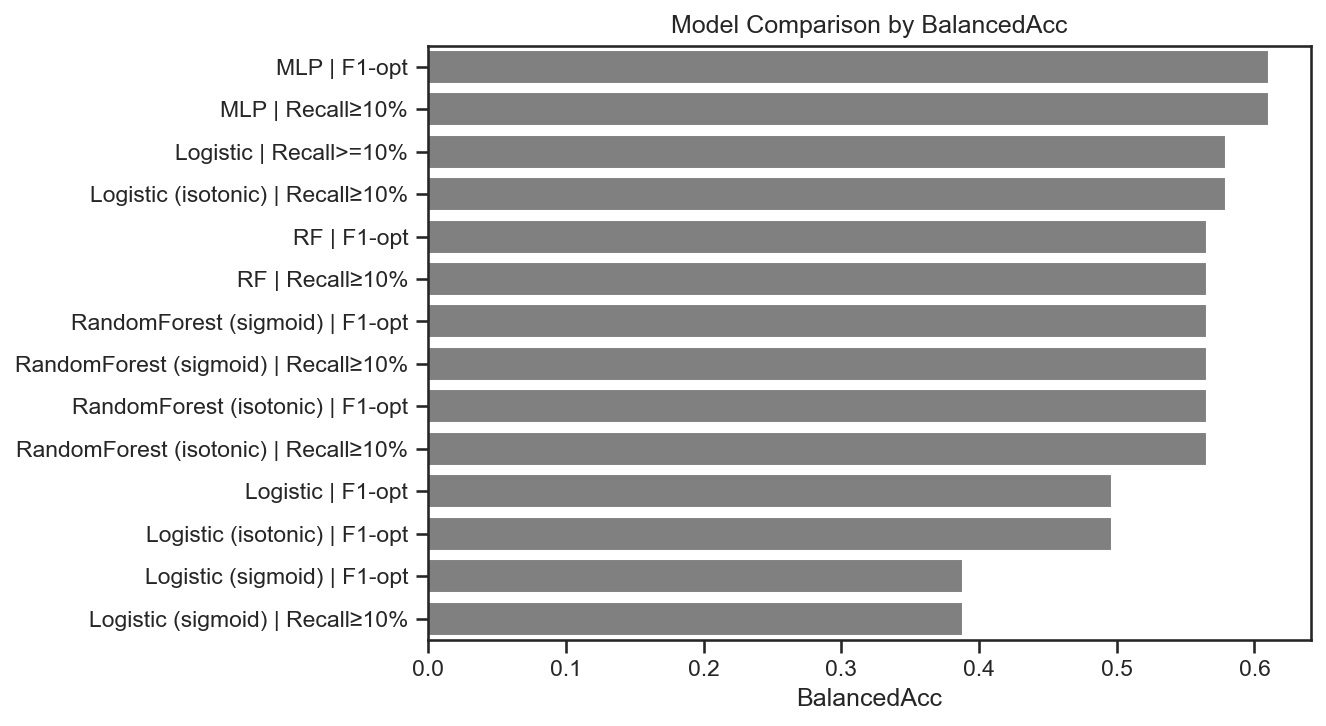

In [26]:
# convert list of dicts directly
df_leader = pd.DataFrame(all_results)

# enforce numeric types
num_cols = ["PR_AUC","ROC_AUC","BalancedAcc","thr","TP","FP","TN","FN"]
for c in num_cols:
    df_leader[c] = pd.to_numeric(df_leader[c], errors="coerce")

# sort by PR_AUC
df_leader = df_leader.sort_values("PR_AUC", ascending=False).reset_index(drop=True)
print(df_leader.round(4))

metrics = ["PR_AUC","ROC_AUC","BalancedAcc"]

for m in metrics:
    plt.figure(figsize=(9,5))
    sns.barplot(data=df_leader.sort_values(m, ascending=False), x=m, y="Model", color="gray")
    plt.title(f"Model Comparison by {m}")
    plt.xlabel(m)
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

#### 6.8. Gradient Boosting (XGBoost or LightGBM)

In [27]:
xgb = XGBClassifier(
        n_estimators=600, learning_rate=0.03, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, reg_alpha=0.0,
        n_jobs=-1, random_state=42, tree_method="hist"
    )
_ = xgb.fit(Xtr, ytr)

In [28]:
p_val = xgb.predict_proba(Xva)[:,1]
pick_f1  = pick_threshold_by_f1(yva, p_val)
pick_rec = pick_threshold_by_recall(yva, p_val, recall_floor=0.10)

p_te = xgb.predict_proba(Xte)[:,1]
xgb_res_f1 = evaluate(yte, p_te, pick_f1["thr"],  name="XGB | F1-opt")
xgb_res_rec= evaluate(yte, p_te, pick_rec["thr"], name="XGB | Recall≥10%")

all_results += [xgb_res_f1, xgb_res_rec]


== XGB | F1-opt @thr=0.003 ==
Confusion: (151, 146, 7, 10) | BalancedAcc: 0.5483 | PR-AUC: 0.0606 | ROC-AUC: 0.5522
              precision    recall  f1-score   support

           0      0.956     0.508     0.664       297
           1      0.064     0.588     0.116        17

    accuracy                          0.513       314
   macro avg      0.510     0.548     0.390       314
weighted avg      0.907     0.513     0.634       314


== XGB | Recall≥10% @thr=0.005 ==
Confusion: (203, 94, 9, 8) | BalancedAcc: 0.577 | PR-AUC: 0.0606 | ROC-AUC: 0.5522
              precision    recall  f1-score   support

           0      0.958     0.684     0.798       297
           1      0.078     0.471     0.134        17

    accuracy                          0.672       314
   macro avg      0.518     0.577     0.466       314
weighted avg      0.910     0.672     0.762       314



#### 6.9. Feature Selection + Retrain

In [29]:
# --- selectors ---
def selector_anova(k): return SelectKBest(score_func=f_classif, k=k)
def selector_mi(k): return SelectKBest(score_func=mutual_info_classif, k=k)
def selector_l1(C): 
    base = LogisticRegression(penalty="l1", solver="liblinear", C=C, class_weight="balanced", max_iter=2000)
    return SelectFromModel(base)

# --- candidate k values ---
k_grid = [20, 40, 60, 100, 150]

experiments = []

# logistic regression with ANOVA/MI
for k in k_grid:
    for sel_name, sel_fn in [("ANOVA", selector_anova), ("MI", selector_mi)]:
        pipe = make_pipeline(StandardScaler(), sel_fn(k), LogisticRegression(max_iter=2000, class_weight="balanced"))
        pipe.fit(Xtr, ytr)
        pv = pipe.predict_proba(Xva)[:,1]
        ap = average_precision_score(yva, pv)
        experiments.append({"selector": f"{sel_name}-k{k}", "model":"Logistic", "val_ap": ap, "pipe": pipe})

# logistic regression with L1 selection
for C in [0.1, 1.0]:
    sel = selector_l1(C)
    pipe = make_pipeline(StandardScaler(), sel, LogisticRegression(max_iter=2000, class_weight="balanced"))
    pipe.fit(Xtr, ytr)
    pv = pipe.predict_proba(Xva)[:,1]
    ap = average_precision_score(yva, pv)
    experiments.append({"selector": f"L1-C{C}", "model":"Logistic", "val_ap": ap, "pipe": pipe})

# pick top-3, retrain with MLP head
top3 = sorted(experiments, key=lambda d: d["val_ap"], reverse=True)[:3]
for exp in top3:
    label = exp["selector"]
    sel = exp["pipe"].steps[1][1]  # reuse fitted selector
    pipe = make_pipeline(StandardScaler(), sel, MLPClassifier(hidden_layer_sizes=(64,32), max_iter=600))
    pipe.fit(Xtr, ytr)
    pv = pipe.predict_proba(Xva)[:,1]
    ap = average_precision_score(yva, pv)
    experiments.append({"selector": label, "model":"MLP", "val_ap": ap, "pipe": pipe})

# --- pick winner ---
best = max(experiments, key=lambda d: d["val_ap"])
print("Best on validation:", best["selector"], best["model"], "Val PR-AUC:", round(best["val_ap"],4))

# --- test evaluation ---
pv = best["pipe"].predict_proba(Xva)[:,1]
thr = pick_threshold_by_f1(yva, pv)
pt = best["pipe"].predict_proba(Xte)[:,1]
best_res = evaluate(yte, pt, thr["thr"], name=f"{best['model']} + {best['selector']}")

# store
best_res["Model"] = f"{best['model']} + {best['selector']}"
all_results.append(best_res)

Best on validation: ANOVA-k20 MLP Val PR-AUC: 0.0712

== MLP + ANOVA-k20 @thr=0.002 ==
Confusion: (230, 67, 12, 5) | BalancedAcc: 0.5343 | PR-AUC: 0.0832 | ROC-AUC: 0.5249
              precision    recall  f1-score   support

           0      0.950     0.774     0.853       297
           1      0.069     0.294     0.112        17

    accuracy                          0.748       314
   macro avg      0.510     0.534     0.483       314
weighted avg      0.903     0.748     0.813       314



#### 6.10. Ensembles: averaging + stacking

In [30]:
# Average Ensemble of LR, RF, MLP
# ensure you have probas from previous models: proba_lr, proba_rf, proba_mlp
avg_val = (lr_proba_val + rf_proba_val + mlp_proba_val) / 3
avg_test = (lr_proba_te + rf_proba_te + mlp_proba_te) / 3

thr_avg = pick_threshold_by_f1(yva, avg_val)
avg_res_f1 = evaluate(yte, avg_test, thr_avg["thr"], name="AvgEnsemble | F1-opt")

thr_avg_rec = pick_threshold_by_recall(yva, avg_val, recall_floor=0.10)
avg_res_rec = evaluate(yte, avg_test, thr_avg_rec["thr"], name="AvgEnsemble | Recall≥10%")


== AvgEnsemble | F1-opt @thr=0.202 ==
Confusion: (257, 40, 10, 7) | BalancedAcc: 0.6385 | PR-AUC: 0.116 | ROC-AUC: 0.7314
              precision    recall  f1-score   support

           0      0.963     0.865     0.911       297
           1      0.149     0.412     0.219        17

    accuracy                          0.841       314
   macro avg      0.556     0.639     0.565       314
weighted avg      0.918     0.841     0.874       314


== AvgEnsemble | Recall≥10% @thr=0.202 ==
Confusion: (257, 40, 10, 7) | BalancedAcc: 0.6385 | PR-AUC: 0.116 | ROC-AUC: 0.7314
              precision    recall  f1-score   support

           0      0.963     0.865     0.911       297
           1      0.149     0.412     0.219        17

    accuracy                          0.841       314
   macro avg      0.556     0.639     0.565       314
weighted avg      0.918     0.841     0.874       314



In [31]:
all_results += [avg_res_f1, avg_res_rec]

In [32]:
# --- Stacking Ensemble (meta-learner = Logistic Regression) ---
Xval_stack = np.vstack([lr_proba_val, rf_proba_val, mlp_proba_val]).T
Xte_stack  = np.vstack([lr_proba_te, rf_proba_te, mlp_proba_te]).T

meta = LogisticRegression(max_iter=2000, class_weight="balanced")
meta.fit(Xval_stack, yva)
stack_val = meta.predict_proba(Xval_stack)[:,1]
stack_test = meta.predict_proba(Xte_stack)[:,1]

thr_stack = pick_threshold_by_f1(yva, stack_val)
stack_res_f1 = evaluate(yte, stack_test, thr_stack["thr"], name="Stacking | F1-opt")

thr_stack_rec = pick_threshold_by_recall(yva, stack_val, recall_floor=0.10)
stack_res_rec = evaluate(yte, stack_test, thr_stack_rec["thr"], name="Stacking | Recall≥10%")


== Stacking | F1-opt @thr=0.507 ==
Confusion: (248, 49, 12, 5) | BalancedAcc: 0.5646 | PR-AUC: 0.0847 | ROC-AUC: 0.6601
              precision    recall  f1-score   support

           0      0.954     0.835     0.890       297
           1      0.093     0.294     0.141        17

    accuracy                          0.806       314
   macro avg      0.523     0.565     0.516       314
weighted avg      0.907     0.806     0.850       314


== Stacking | Recall≥10% @thr=0.507 ==
Confusion: (248, 49, 12, 5) | BalancedAcc: 0.5646 | PR-AUC: 0.0847 | ROC-AUC: 0.6601
              precision    recall  f1-score   support

           0      0.954     0.835     0.890       297
           1      0.093     0.294     0.141        17

    accuracy                          0.806       314
   macro avg      0.523     0.565     0.516       314
weighted avg      0.907     0.806     0.850       314



In [33]:
all_results += [stack_res_f1, stack_res_rec]

Final Leaderboard (sorted by PR-AUC):


,Model,PR_AUC,ROC_AUC,BalancedAcc,thr,TP,FP,TN,FN
0,Logistic | F1-opt,0.1196,0.6425,0.4966,0.9536,0,2,295,17
1,Logistic | Recall>=10%,0.1196,0.6425,0.5793,0.0000,13,180,117,4
2,AvgEnsemble | Recall≥10%,0.1160,0.7314,0.6385,0.2021,7,40,257,10
3,AvgEnsemble | F1-opt,0.1160,0.7314,0.6385,0.2021,7,40,257,10
4,Stacking | F1-opt,0.0847,0.6601,0.5646,0.5068,5,49,248,12
5,Stacking | Recall≥10%,0.0847,0.6601,0.5646,0.5068,5,49,248,12
6,MLP + ANOVA-k20,0.0832,0.5249,0.5343,0.0018,5,67,230,12
7,MLP | Recall≥10%,0.0736,0.5847,0.6105,0.1509,12,144,153,5
8,MLP | F1-opt,0.0736,0.5847,0.6105,0.1509,12,144,153,5
9,RandomForest (sigmoid) | F1-opt,0.0715,0.6172,0.5653,0.0398,8,101,196,9


Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/modeling/01_model_leaderboard_pr_auc.png


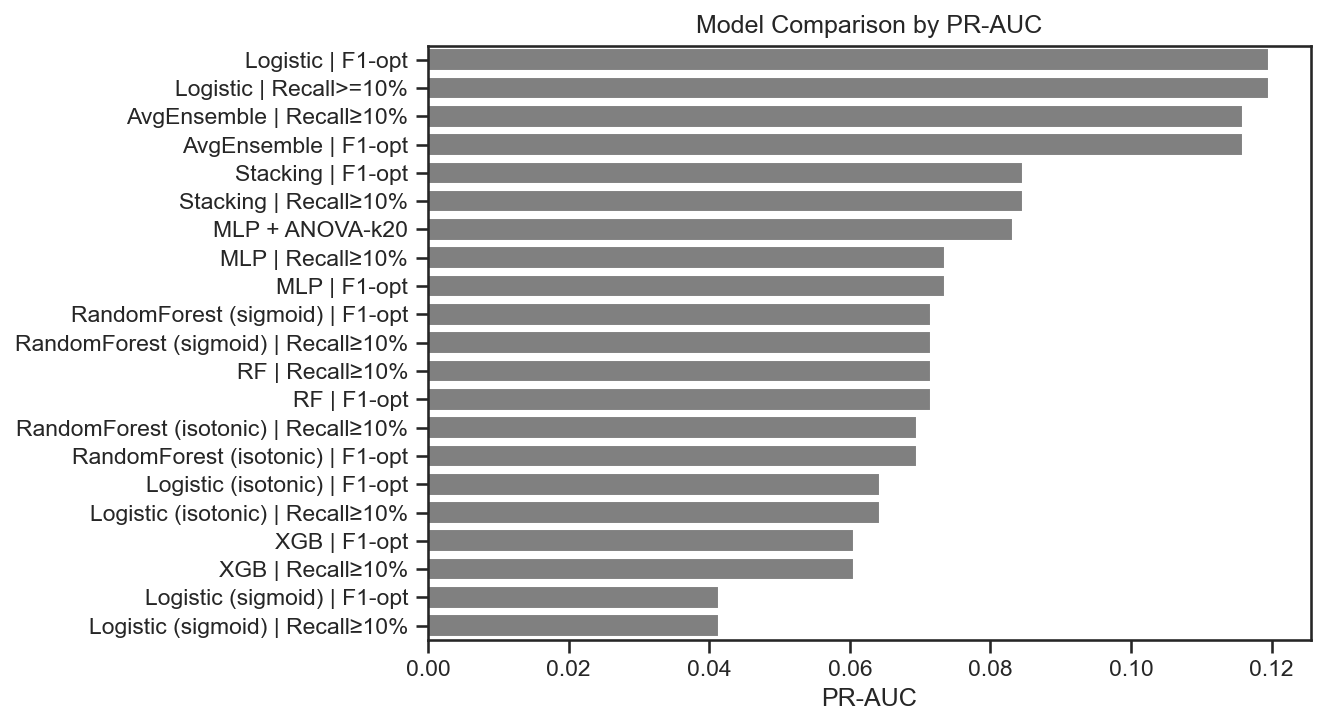

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/modeling/02_model_leaderboard_roc_auc.png


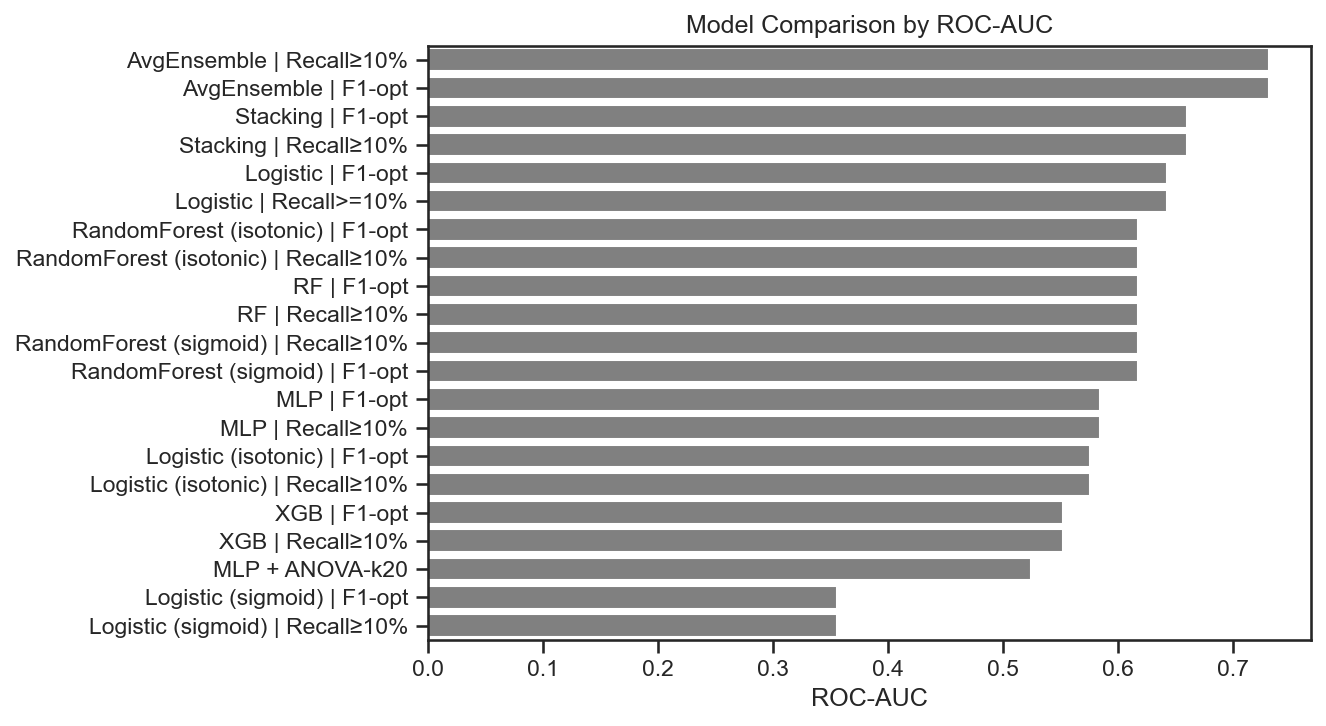

In [34]:
# required columns are already in all_results
cols = ["Model","PR_AUC","ROC_AUC","BalancedAcc","thr","TP","FP","TN","FN"]

df_leader = (pd.DataFrame(all_results)[cols]
             .drop_duplicates()
             .sort_values("PR_AUC", ascending=False)
             .reset_index(drop=True))

print("Final Leaderboard (sorted by PR-AUC):")
display(df_leader.round(4))

# save
df_leader.to_csv(RESULT_DIR/"modeling_final_leaderboard.csv", index=False)

# quick plots
plt.figure(figsize=(9,5))
sns.barplot(data=df_leader, x="PR_AUC", y="Model", color="gray")
plt.title("Model Comparison by PR-AUC")
plt.xlabel("PR-AUC")
plt.ylabel("")
plt.tight_layout()
savefig("01_model_leaderboard_pr_auc.png")
plt.show()

plt.figure(figsize=(9,5))
sns.barplot(data=df_leader.sort_values("ROC_AUC", ascending=False),
            x="ROC_AUC", y="Model", color="gray")
plt.title("Model Comparison by ROC-AUC")
plt.xlabel("ROC-AUC")
plt.ylabel("")
plt.tight_layout()
savefig("02_model_leaderboard_roc_auc.png")
plt.show()

#### 6.11. Save all the models.

In [35]:
joblib.dump(lr, MODEL_DIR/"logistic.pkl")
joblib.dump(rf, MODEL_DIR/"random_forest.pkl")
joblib.dump(xgb, MODEL_DIR/"xgb.pkl")

# feature-selection winner
best_pipe = best['pipe']
joblib.dump(best_pipe, MODEL_DIR/"feature_select_winner.pkl")

# stacking meta
joblib.dump(meta, MODEL_DIR/"stack_meta.pkl")

# torch MLP
torch.save(mlp_model.state_dict(), MODEL_DIR/"mlp_state.pt")